In [402]:
import ArticleComparator as ac
import csv 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")

from graph import Graph

In [403]:
truth_graph = Graph()
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False )

# Exploring the graph gided by semantics:

**The idea of this part is to understand how people hwo won the game did to navigate through this huge graph. More specifically we try to see how semantic did influnce the chosen paths**

To do so we first start by creating a dataframe that contains all the finished paths.
The data frame will have 4 entries at this stage :
- The path : which is the list of nodes that the player went through
- Start : the starting node
- End : the ending node
- length : the length of the path

However we will discard paths where backclicking is done.

In [404]:
# Create a df with path, start, end, length
df_paths_finished = pd.DataFrame(columns=['path', 'start', 'end', 'length'])
counter = 0
discarded_paths = 0

# Read the paths from the paths_finished.tsv file
with open("data/paths_finished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            #For each line in the file
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                    if path.__contains__('<') or path.__contains__('Pikachu'):
                        discarded_paths += 1
                        continue
                    # Set the start node as the fist node in the path
                    start = path[0]
                    # Set the end node as the last node in the path
                    end = path[-1]
                    # Set the length of the path
                    length = len(path)
                    # Add the path to the dataframe
                    df_paths_finished.loc[counter] = [path, start, end, length]
                    counter += 1
print("Discarded paths due to backclicks: ", discarded_paths)
print("Number of paths retained: ", len(df_paths_finished))

Discarded paths due to backclicks:  9052
Number of paths retained:  42266


For obvious reasons we will also discard trivial paths (length 1)

In [405]:
print("Number of trivial paths: ", len(df_paths_finished[df_paths_finished['length'] == 1]))
df_paths_finished = df_paths_finished[df_paths_finished['length'] > 1]

Number of trivial paths:  11


In [406]:
df_paths_finished

,path,start,end,length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
42261,"[Work_%28thermodynamics%29, Energy, Aristotle,...",Work_%28thermodynamics%29,Film,13
42262,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
42263,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_%28tennis%29,7
42264,"[Yarralumla%2C_Australian_Capital_Territory, A...",Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,4


Next we want to see if the link chosen by the player are sementically closer or not to the target article.
Here we distinguish 2 metrics :
- Article similarity 
- Tile similarity

Article similarity is the similarity between the target article and the article that the player clicked on.
Tile similarity is the similarity between the title of the target article and the title of the article that the player clicked on.

In order to compute these metrics we use the BERT model to compute the embeddings of the articles and the titles.
Then we compute the cosine similarity between the embeddings.

Remember that at the start of the notebook we cretated an object of type ArticleComparator that stores the embeddings of the articles and the titles.
Now we will use the methods of this object to compute the similarity metrics.

In [407]:
#Initiate the comparator
article_list = truth_graph.articles
article_comparator = ac.ArticleComparator("data/plaintext_articles/", article_list)

In [408]:
# For each path, compute the similarity between the articles in the path and the end article
df_paths_finished['article_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
# For each path, compute the similarity between the title of the articles in the path and the title of the end article
df_paths_finished['title_similarity'] = df_paths_finished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

In [409]:
df_paths_finished.sample(10)

,path,start,end,length,article_similarity,title_similarity
5785,"[Paleontology, Biodiversity, Biology, Biosphere]",Paleontology,Biosphere,4,"[0.36, 0.32, 0.35, 1.0]","[0.6, 0.78, 0.74, 1.0]"
33614,"[Imperial_Japanese_Navy, World_War_II, Poland,...",Imperial_Japanese_Navy,Carolus_Linnaeus,5,"[0.37, 0.29, 0.42, 0.67, 1.0]","[0.38, 0.32, 0.48, 0.61, 1.0]"
38299,"[Scattered_disc, Sun, Climate, Sea, South_Chin...",Scattered_disc,Actor,11,"[0.15, 0.09, 0.08, 0.12, 0.14, 0.25, 0.03, 0.2...","[0.55, 0.5, 0.51, 0.46, 0.29, 0.36, 0.42, 0.43..."
325,"[Aircraft, United_Kingdom, Bangladesh]",Aircraft,Bangladesh,3,"[0.22, 0.34, 1.0]","[0.46, 0.47, 1.0]"
16487,"[European_Union, Greece, Homer, Odyssey, Odyss...",European_Union,Odysseus,5,"[0.3, 0.58, 0.71, 0.49, 1.0]","[0.56, 0.66, 0.59, 0.76, 1.0]"
41881,"[Sonic_the_Hedgehog_%28character%29, Drosophil...",Sonic_the_Hedgehog_%28character%29,Cancer,3,"[0.22, 0.43, 1.0]","[0.27, 0.37, 1.0]"
19997,"[Cider, Plum, Tree]",Cider,Tree,3,"[0.27, 0.23, 1.0]","[0.45, 0.52, 1.0]"
19244,"[Gull, Animal, Plant, Agriculture, Vegetable]",Gull,Vegetable,5,"[0.25, 0.0, 0.05, 0.61, 1.0]","[0.48, 0.55, 0.75, 0.74, 1.0]"
24524,"[Cheese, Germany, The_Holocaust, Adolf_Hitler]",Cheese,Adolf_Hitler,4,"[0.26, 0.6, 0.63, 1.0]","[0.3, 0.65, 0.66, 1.0]"
35553,"[Mercantilism, Germany, Netherlands, Dutch_lan...",Mercantilism,Hollandic,5,"[0.27, 0.34, 0.4, 0.14, 1.0]","[0.65, 0.49, 0.8, 0.76, 1.0]"


Now we need a way to evaluate the quality of the paths.
We consider that a path is good if it get semantically closer to the target article :
- [0.26, 0.38, 0.48, 1.0] is a good path because the similarity is increasing
- [0.26, 0.38, 0.28, 0.4, 0.20, 1.0] is a bad path because the similarity is oscillating

In [410]:
def path_score(sequence):
  # Initialize the score to 0
  score = 0
  
  # Loop through the numbers in the sequence, starting at the second number
  for i in range(1, len(sequence)):
    # If the difference between the current number and the previous number is less than 0.05, add 0 to the score
    if np.abs(sequence[i] - sequence[i-1]) < 0.05:
      score += 0
    # If the next article is more similar than the previous article, add 1 to the score
    elif sequence[i] > sequence[i-1]:
      score += 1
    # If the next article is less similar than the previous article, subtract 1 from the score
    elif sequence[i] < sequence[i-1]:
      score -= 1
    
  return np.clip((score/((len(sequence)-1))), 0, 1).round(2)

We assign to each path two scores :
- The score of the path based on the article similarity 
- The score of the path based on the title similarity

In [411]:
df_paths_finished['score_article_similarity'] = df_paths_finished.apply(lambda row: path_score(row['article_similarity']), axis=1)
df_paths_finished['score_title_similarity'] = df_paths_finished.apply(lambda row: path_score(row['title_similarity']), axis=1)

In [412]:
df_paths_finished.sort_values(by=['score_article_similarity'], ascending=False)

,path,start,end,length,article_similarity,title_similarity,score_article_similarity,score_title_similarity
9777,"[San_Jose%2C_California, World_War_II, Adolf_H...",San_Jose%2C_California,Adolf_Hitler,3,"[0.34, 0.57, 1.0]","[0.42, 0.62, 1.0]",1.0,1.00
26183,"[Lithium, Plant, Gardening]",Lithium,Gardening,3,"[0.14, 0.34, 1.0]","[0.29, 0.79, 1.0]",1.0,1.00
4756,"[Jew, Hebrew_language]",Jew,Hebrew_language,2,"[0.66, 1.0]","[0.71, 1.0]",1.0,1.00
26190,"[Lanthanum, Periodic_table, Russia, Russian_Re...",Lanthanum,Russian_Revolution_of_1917,4,"[0.45, 0.55, 0.68, 1.0]","[0.33, 0.35, 0.73, 1.0]",1.0,0.67
4754,"[Jew, The_Holocaust, Adolf_Hitler]",Jew,Adolf_Hitler,3,"[0.39, 0.63, 1.0]","[0.44, 0.66, 1.0]",1.0,1.00
...,...,...,...,...,...,...,...,...
28121,"[African_clawed_frog, Frog, Eye, Cornea]",African_clawed_frog,Cornea,4,"[0.37, 0.33, 0.22, 1.0]","[0.27, 0.42, 0.69, 1.0]",0.0,1.00
28123,"[Afrikaans, Botswana, Tourism, Infrastructure,...",Afrikaans,United_Arab_Emirates,10,"[0.39, 0.2, 0.4, 0.34, 0.2, 0.43, 0.31, 0.62, ...","[0.51, 0.45, 0.45, 0.53, 0.5, 0.47, 0.48, 0.6,...",0.0,0.33
28129,"[Afrikaans, Slavery, Irish_people, Ireland, Mi...",Afrikaans,Canola,13,"[0.42, 0.23, 0.27, 0.43, 0.37, 0.04, 0.24, 0.3...","[0.61, 0.46, 0.5, 0.59, 0.57, 0.51, 0.45, 0.62...",0.0,0.00
28134,"[Agamemnon, Bible, Jew, Birth_control, Ethics,...",Agamemnon,Genetics,6,"[0.44, 0.45, 0.47, 0.5, 0.45, 1.0]","[0.37, 0.47, 0.43, 0.53, 0.46, 1.0]",0.0,0.40


Then we classify the paths based on the score of the article similarity and the score of the title similarity.
- **Type 0 paths:**  paths that have similar score for both article similarity and title similarity
- **Type 1 paths:**  paths that have better score for article similarity than title similarity
- **Type 2 paths:**  paths that have better score for title similarity than article similarity

In [413]:
df_paths_finished['type'] = df_paths_finished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else 1 if row['score_article_similarity'] > row['score_title_similarity'] else 2, axis=1)

In [414]:
# show proportion of paths with score 0, 1, 2
df_paths_finished['type'].value_counts(normalize=True).to_frame().sort_index()

,type
0,0.316341
1,0.227571
2,0.456088


We can see that the majority of the paths (45% $\simeq$ half of the paths) are type 2 paths. <br>
That means that the player is more likely to click on a link that has a similar title to the target article. <br><br>

We can also see that the type 0 paths are repreents a good chunck of the paths but we cannot interpret if he player is more likely to click on a link that has a similar title or content to the target article. <br>


To continue our analysis, we drop all path where of non frquenet lengths(that are inferior to 100) since they are not representative of the whole population.

In [415]:
# drop the entries where the length appear less than 100 times
print("Number of paths before filtering: ", len(df_paths_finished))
df_paths_multiple = df_paths_finished.groupby('length').filter(lambda x: len(x) > 100)
print("Number of paths after filtering: ", len(df_paths_multiple))

Number of paths before filtering:  42255
Number of paths after filtering:  41914


Let's now see the distribution of the path lengths based on the type of the path.

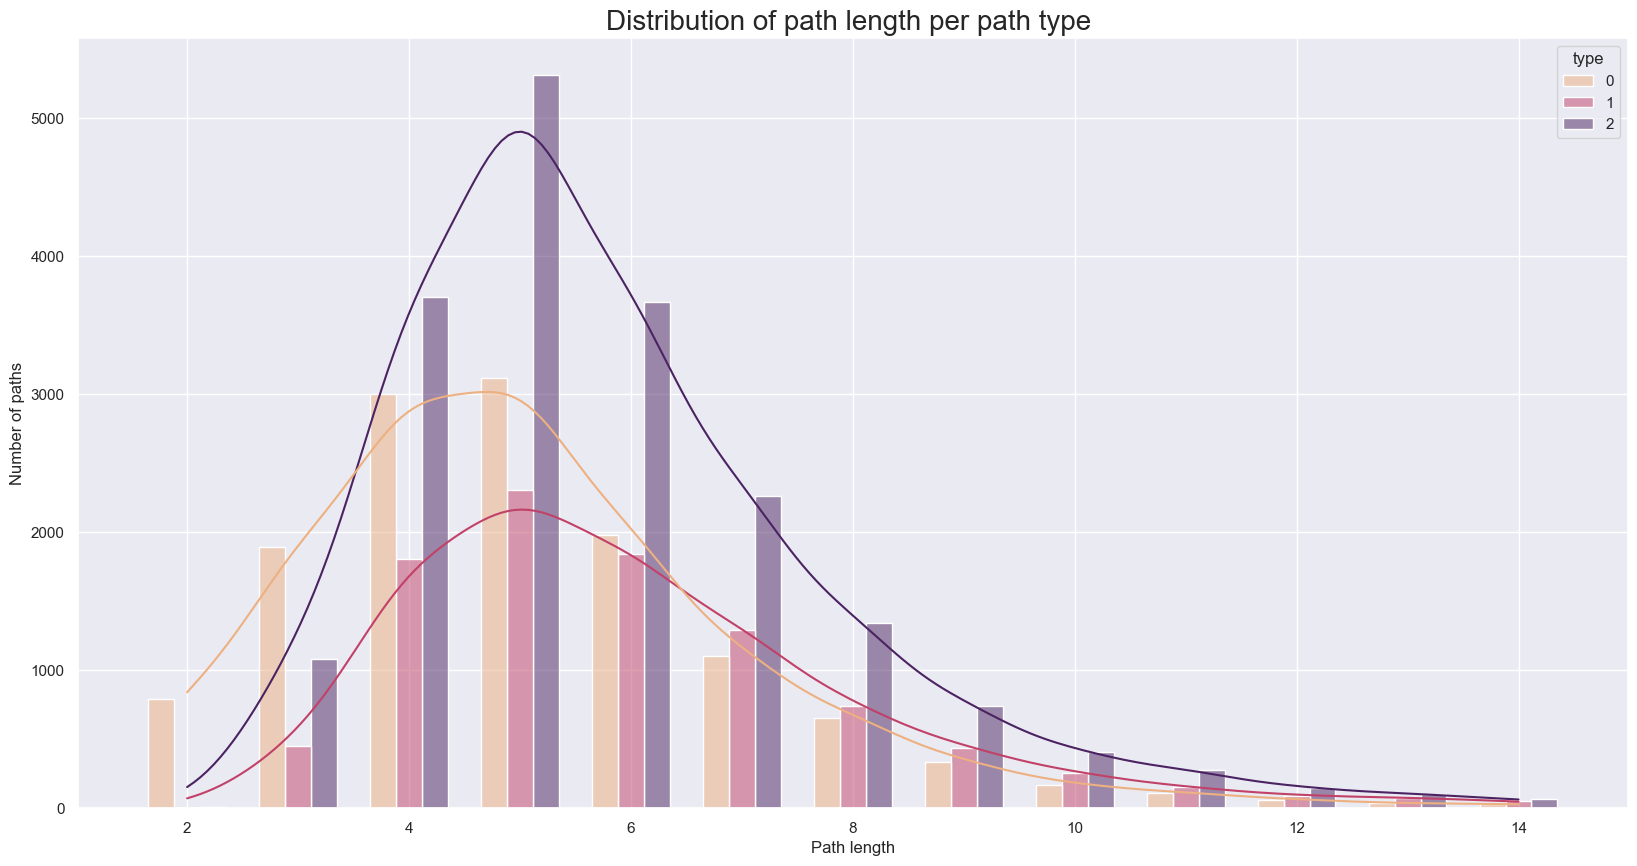

Average path length:  5.617216204609439
Median path length:  5.0
Standard deviation of path length:  2.0090258529655713


In [416]:
# plot the distribution of the type per length using hue type histplot plot and kde=true, 
sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")
fig, ax = plt.subplots( figsize=(20, 10))
sns.histplot(data=df_paths_multiple, x="length", hue="type",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, ax=ax, kde_kws={'bw_method': 0.28})
ax.set_xlabel("Path length")
ax.set_ylabel("Number of paths")
ax.set_title("Distribution of path length per path type ", fontsize=20)
plt.show()

# print average, median path length and standard deviation
print("Average path length: ", df_paths_multiple['length'].mean())
print("Median path length: ", df_paths_multiple['length'].median())
print("Standard deviation of path length: ", df_paths_multiple['length'].std())

From the above plot we can see that type 0 paths are the most frequent one when the length of the path is small (>4). <br>
This is not surprising since the scores for content and title similarity are likely to evolve similarly in such short paths <br> <br>
However, starting from length 4 we see a predominance of type 2 paths : as the solution becomes less obvious, the player is more likely to click on a link that has a similar title to the target article. <br>

<AxesSubplot: title={'center': 'Proportion of paths types per length'}, xlabel='length'>

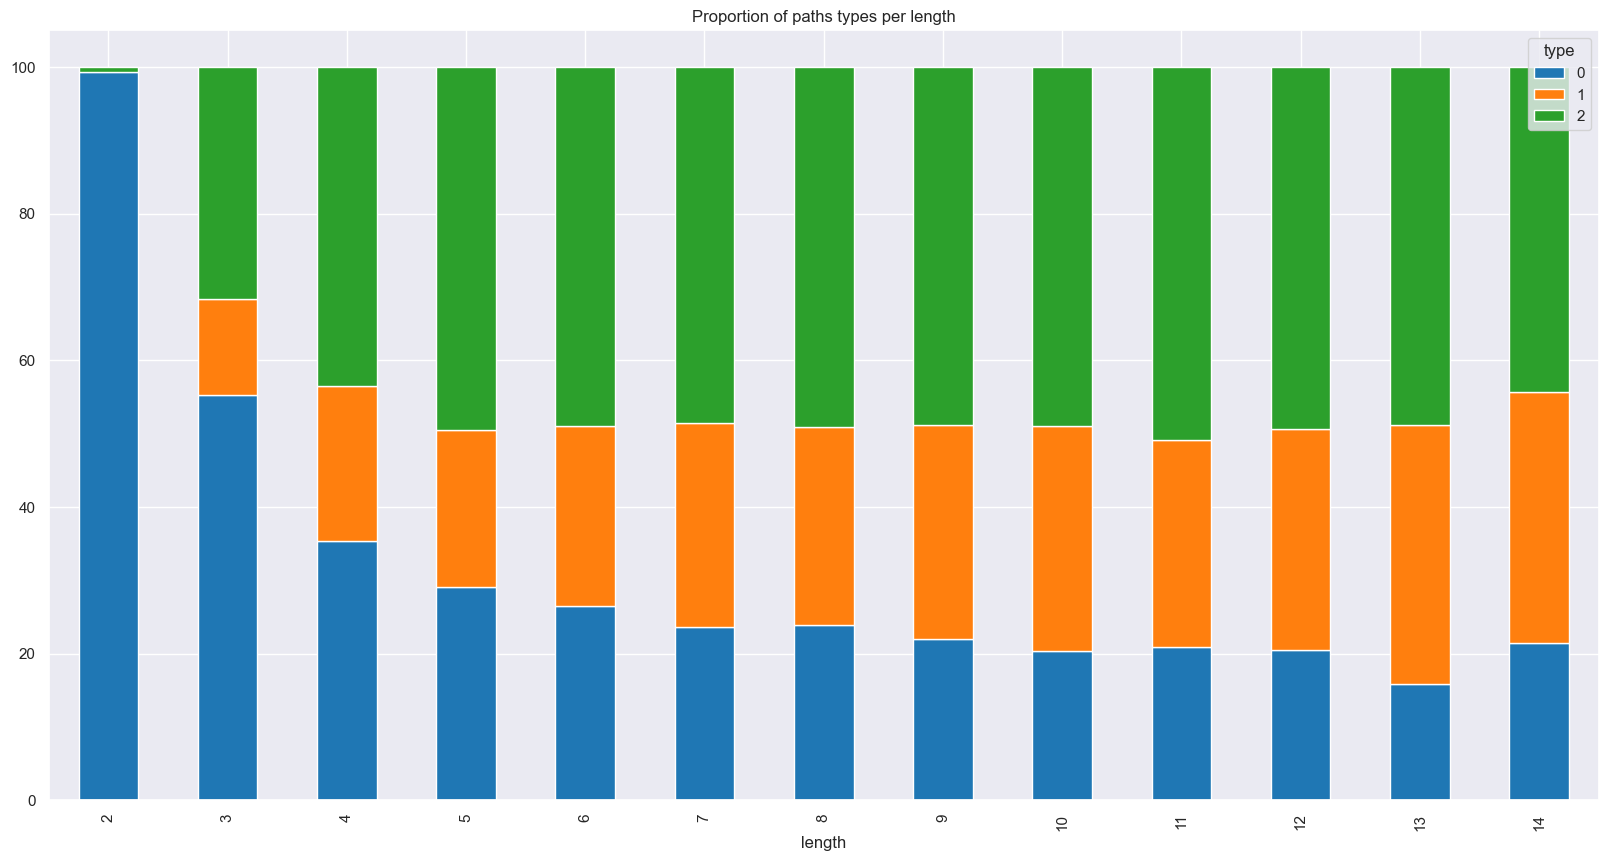

In [417]:
# plot the percentage of playerType 0, 1, 2 per length 
type_repartition = df_paths_multiple.groupby(['length', 'type'], group_keys=False).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum())).unstack()

# set the color of the bars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
type_repartition.plot(kind='bar', stacked=True, figsize=(20,10), title='Proportion of paths types per length', color=colors, ax=ax)


 Todo : Interpret the results from above 
 

Knowing that type 2 paths are the most frequent ones, we can now ask ourselves if they are shorter than type 1 paths. <br><br>
To do so we have to compare the average length of type 1 and type 2 paths by doing an observational study.<br>
Thus, we do matchings between type 1 and type 2 paths based on the start and end article. <br>

In [418]:
# inner join on df_paths_multiple with itself on start and end
matching = df_paths_multiple.merge(df_paths_multiple, on=['start', 'end'])
# drop the rows where the path_x is equal to the path_y
matching = matching[matching['type_x'] != matching['type_y']]
# drop the rows where the type_x or type_y is equal to 0
matching = matching[(matching['type_x'] != 0) & (matching['type_y'] != 0)]
# only keep type_x, type_y, length_x, length_y, path_x, path_y
matching = matching[['path_x', 'path_y', 'type_x', 'type_y', 'length_x', 'length_y']]
# rename the columns
matching.columns = [ 'path1', 'path2', 'type1', 'type2', 'length1', 'length2']
# keep the rows where type1 is equal to 1 and type2 is equal to 2
matching = matching[(matching['type1'] == 1) & (matching['type2'] == 2)]

# print the size of the matching dataframe
print("Number of paths matching: ", len(matching))

matching

Number of paths matching:  196124


,path1,path2,type1,type2,length1,length2
2,"[14th_century, 15th_century, 16th_century, Pac...","[14th_century, Niger, Nigeria, British_Empire,...",1,2,9,8
455,"[14th_century, Time, Egypt, Ancient_Egypt, Gla...","[14th_century, Time, Isaac_Newton, Light, Colo...",1,2,8,6
456,"[14th_century, Time, Egypt, Ancient_Egypt, Gla...","[14th_century, Time, Light, Rainbow]",1,2,8,4
457,"[14th_century, Time, Egypt, Ancient_Egypt, Gla...","[14th_century, 15th_century, Plato, Nature, Ul...",1,2,8,7
458,"[14th_century, Time, Egypt, Ancient_Egypt, Gla...","[14th_century, Christianity, Bible, God, Natur...",1,2,8,10
...,...,...,...,...,...,...
2365125,"[Civilization_%28computer_game%29, Civilizatio...","[Civilization_%28computer_game%29, Mythology, ...",1,2,6,5
2365200,"[Final_Fantasy_%28video_game%29, English_langu...","[Final_Fantasy_%28video_game%29, Space_station...",1,2,4,5
2365201,"[Final_Fantasy_%28video_game%29, English_langu...","[Final_Fantasy_%28video_game%29, Nintendo_Ente...",1,2,4,6
2365230,"[Firefly_%28TV_series%29, People%27s_Republic_...","[Firefly_%28TV_series%29, DVD, Compact_Disc, M...",1,2,3,13


Then we compare the average length of the type 1 paths and the type 2 paths.

In [436]:
# average type 1 path length 
print("Average type 1 path length: ", matching['length1'].mean().__round__(2))
# average type 2 path length
print("Average type 2 path length: ", matching['length2'].mean().__round__(2))
# average difference between type 1 and type 2 path length
print("Average difference between type 1 and type 2 path length: ", (matching['length1'] - matching['length2']).mean().__round__(2))
# average relative decrease in path length
print("Average relative decrease in path length: ", ((matching['length1'] - matching['length2']).mean()/matching['length1'].mean()).__round__(2))

Average type 1 path length:  6.72
Average type 2 path length:  6.52
Average difference between type 1 and type 2 path length:  0.21
Average relative decrease in path length:  0.03


We can conclude that the type 2 paths are on average 3% Shorter than the type 1 paths. <br>
Thus it is more efficient for players to click on a link that has a similar title to the target article.

# Further analysis will come soon 

# Unfinished paths

In [420]:
# create a df with path, start, end, length
df_paths_unfinished = pd.DataFrame(columns=['path', 'start', 'end', 'length'])
counter = 0

# chek that a list of string named articles contains all elements list of string named list2
def contains_all(articles, path):
    for element in path:
        if not articles.__contains__(element):
            return False
    return True

with open("data/paths_unfinished.tsv",encoding="utf8") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            for line in tsv_file:
                # Skip empty or commented lines 
                if len(line)==0 or line[0].startswith("#"):
                    continue
                else:   
                    path = line[3].split(';')
                    if path.__contains__('<') or path.__contains__('Pikachu') or line[4]=='Pikachu' or not contains_all(article_list, path) or not article_list.__contains__(line[4]):
                        continue
                    
                    start = path[0]
                    end = line[4]
                    length = len(path)
                    df_paths_unfinished.loc[counter] = [path, start, end, length]
                    counter += 1

In [421]:
df_paths_unfinished

,path,start,end,length
0,[Obi-Wan_Kenobi],Obi-Wan_Kenobi,Microsoft,1
1,[Julius_Caesar],Julius_Caesar,Caracas,1
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3
3,[Paraguay],Paraguay,Mount_St._Helens,1
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2
...,...,...,...,...
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6
19626,[Modern_history],Modern_history,Hollandic,1
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4


In [422]:
# drop paths of length 1
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished['length'] > 1]

In [423]:
df_paths_unfinished['article_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
df_paths_unfinished['title_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_titles(article, row['end']) for article in row['path']], axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_23040/1972011756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['article_similarity'] = df_paths_unfinished.apply(lambda row: [article_comparator.compare_articles(article, row['end']) for article in row['path']], axis=1)
/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_23040/1972011756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['title_similarity'] = df_paths_unfinished.apply(lambda row:

In [424]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.32, 0.29, 0.47]","[0.39, 0.36, 0.5]"
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.29, 0.39]","[0.43, 0.47]"
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.14, 0.37, 0.57, 0.75]","[0.18, 0.37, 0.76, 0.56]"
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.22, 0.41, 0.48, 0.35, 0.31, 0.27, 0.46]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]"
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.18, 0.28, 0.13, 0.36, 0.32]","[0.45, 0.3, 0.34, 0.57, 0.29]"
...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.35, 0.34, 0.44, 0.43, 0.53, 0.79, 0.78]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]"
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.02, 0.32, 0.25]","[0.22, 0.41, 0.75]"
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.16, 0.3, 0.46, 0.19, 0.63, 0.6]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]"
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.23, 0.44, 0.41, 0.32]","[0.41, 0.6, 0.41, 0.41]"


In [425]:
df_paths_unfinished['score_article_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['article_similarity']), axis=1)
df_paths_unfinished['score_title_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['title_similarity']), axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_23040/4230566007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['score_article_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['article_similarity']), axis=1)
/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_23040/4230566007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['score_title_similarity'] = df_paths_unfinished.apply(lambda row: path_score(row['title_similarity'])

In [426]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity,score_article_similarity,score_title_similarity
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.32, 0.29, 0.47]","[0.39, 0.36, 0.5]",0.50,0.50
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.29, 0.39]","[0.43, 0.47]",1.00,0.00
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.14, 0.37, 0.57, 0.75]","[0.18, 0.37, 0.76, 0.56]",1.00,0.33
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.22, 0.41, 0.48, 0.35, 0.31, 0.27, 0.46]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]",0.33,0.17
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.18, 0.28, 0.13, 0.36, 0.32]","[0.45, 0.3, 0.34, 0.57, 0.29]",0.25,0.00
...,...,...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.35, 0.34, 0.44, 0.43, 0.53, 0.79, 0.78]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]",0.50,0.17
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.02, 0.32, 0.25]","[0.22, 0.41, 0.75]",0.00,1.00
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.16, 0.3, 0.46, 0.19, 0.63, 0.6]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]",0.40,0.60
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.23, 0.44, 0.41, 0.32]","[0.41, 0.6, 0.41, 0.41]",0.00,0.00


In [427]:
# add column 0 if score article  = score tile, 1 id score article > score title, 2 if score article < score title
df_paths_unfinished['type'] = df_paths_unfinished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else 1 if row['score_article_similarity'] > row['score_title_similarity'] else 2, axis=1)

/var/folders/jg/bpl2xhc13x17j6txgdvzf5940000gn/T/ipykernel_23040/3392773228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paths_unfinished['type'] = df_paths_unfinished.apply(lambda row: 0 if row['score_article_similarity'] == row['score_title_similarity'] else 1 if row['score_article_similarity'] > row['score_title_similarity'] else 2, axis=1)


In [428]:
df_paths_unfinished

,path,start,end,length,article_similarity,title_similarity,score_article_similarity,score_title_similarity,type
2,"[Malawi, Democracy, Alexander_the_Great]",Malawi,First_Crusade,3,"[0.32, 0.29, 0.47]","[0.39, 0.36, 0.5]",0.50,0.50,0
4,"[Paraguay, Bolivia]",Paraguay,Mount_St._Helens,2,"[0.29, 0.39]","[0.43, 0.47]",1.00,0.00,1
5,"[Agriculture, History_of_the_world, China, Yan...",Agriculture,Grand_Canal_of_China,4,"[0.14, 0.37, 0.57, 0.75]","[0.18, 0.37, 0.76, 0.56]",1.00,0.33,1
6,"[Mind, Christianity, Europe, Renaissance, Anci...",Mind,Scouting,7,"[0.22, 0.41, 0.48, 0.35, 0.31, 0.27, 0.46]","[0.58, 0.43, 0.52, 0.49, 0.31, 0.4, 0.54]",0.33,0.17,1
7,"[4-2-0, United_States, Agriculture, Sugar, Aus...",4-2-0,Cane_Toad,5,"[0.18, 0.28, 0.13, 0.36, 0.32]","[0.45, 0.3, 0.34, 0.57, 0.29]",0.25,0.00,1
...,...,...,...,...,...,...,...,...,...
19623,"[Montenegro, World_War_II, United_States, Cari...",Montenegro,Hurricane_Georges,7,"[0.35, 0.34, 0.44, 0.43, 0.53, 0.79, 0.78]","[0.37, 0.4, 0.37, 0.45, 0.85, 0.79, 0.75]",0.50,0.17,1
19624,"[Wine, Georgia_%28country%29, Russia]",Wine,History_of_post-Soviet_Russia,3,"[0.02, 0.32, 0.25]","[0.22, 0.41, 0.75]",0.00,1.00,2
19625,"[Turks_and_Caicos_Islands, United_States, Iraq...",Turks_and_Caicos_Islands,Iraq_War,6,"[0.16, 0.3, 0.46, 0.19, 0.63, 0.6]","[0.25, 0.5, 0.9, 0.48, 0.63, 0.7]",0.40,0.60,2
19627,"[Jamaica, United_Kingdom, World_War_II, Battle...",Jamaica,Alan_Turing,4,"[0.23, 0.44, 0.41, 0.32]","[0.41, 0.6, 0.41, 0.41]",0.00,0.00,0


In [429]:
# drop the entries where the length appear less than 10 times
df_paths_multiple_u = df_paths_unfinished.groupby('length').filter(lambda x: len(x) > 100)

<AxesSubplot: title={'center': 'Proportion of paths types per length'}, xlabel='length'>

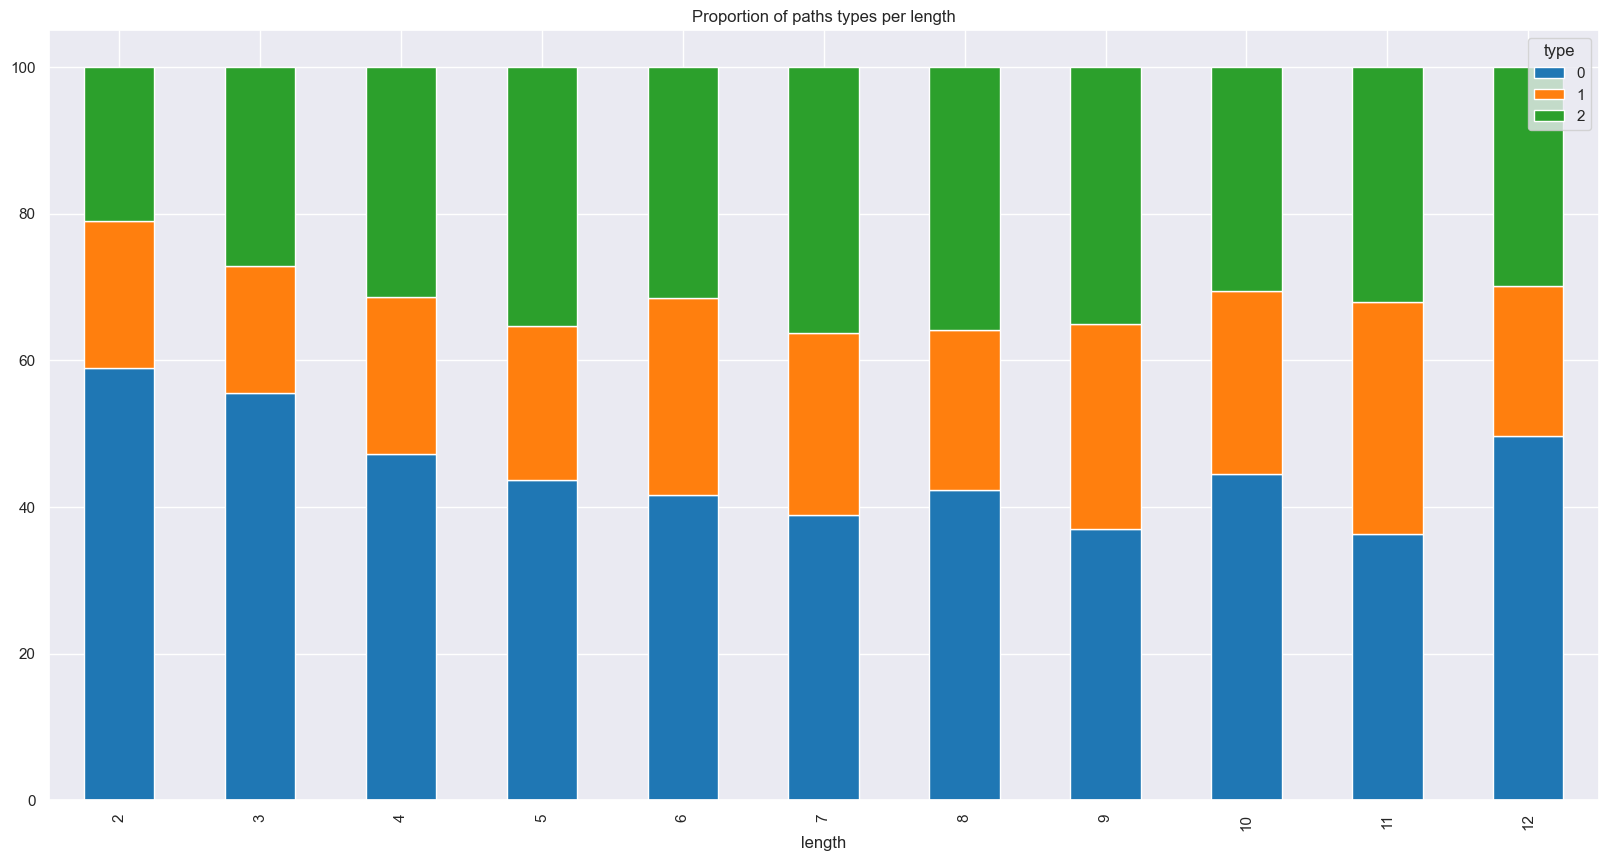

In [430]:
# plot the percentage of playerType 0, 1, 2 per length 
frite = df_paths_multiple_u.groupby(['length', 'type'], group_keys=False).size().groupby(level=0, group_keys=False).apply(lambda x: 100 * x / float(x.sum())).unstack()

# set the color of the bars
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
frite.plot(kind='bar', stacked=True, figsize=(20,10), title='Proportion of paths types per length', color=colors, ax=ax)


<AxesSubplot: xlabel='length', ylabel='Count'>

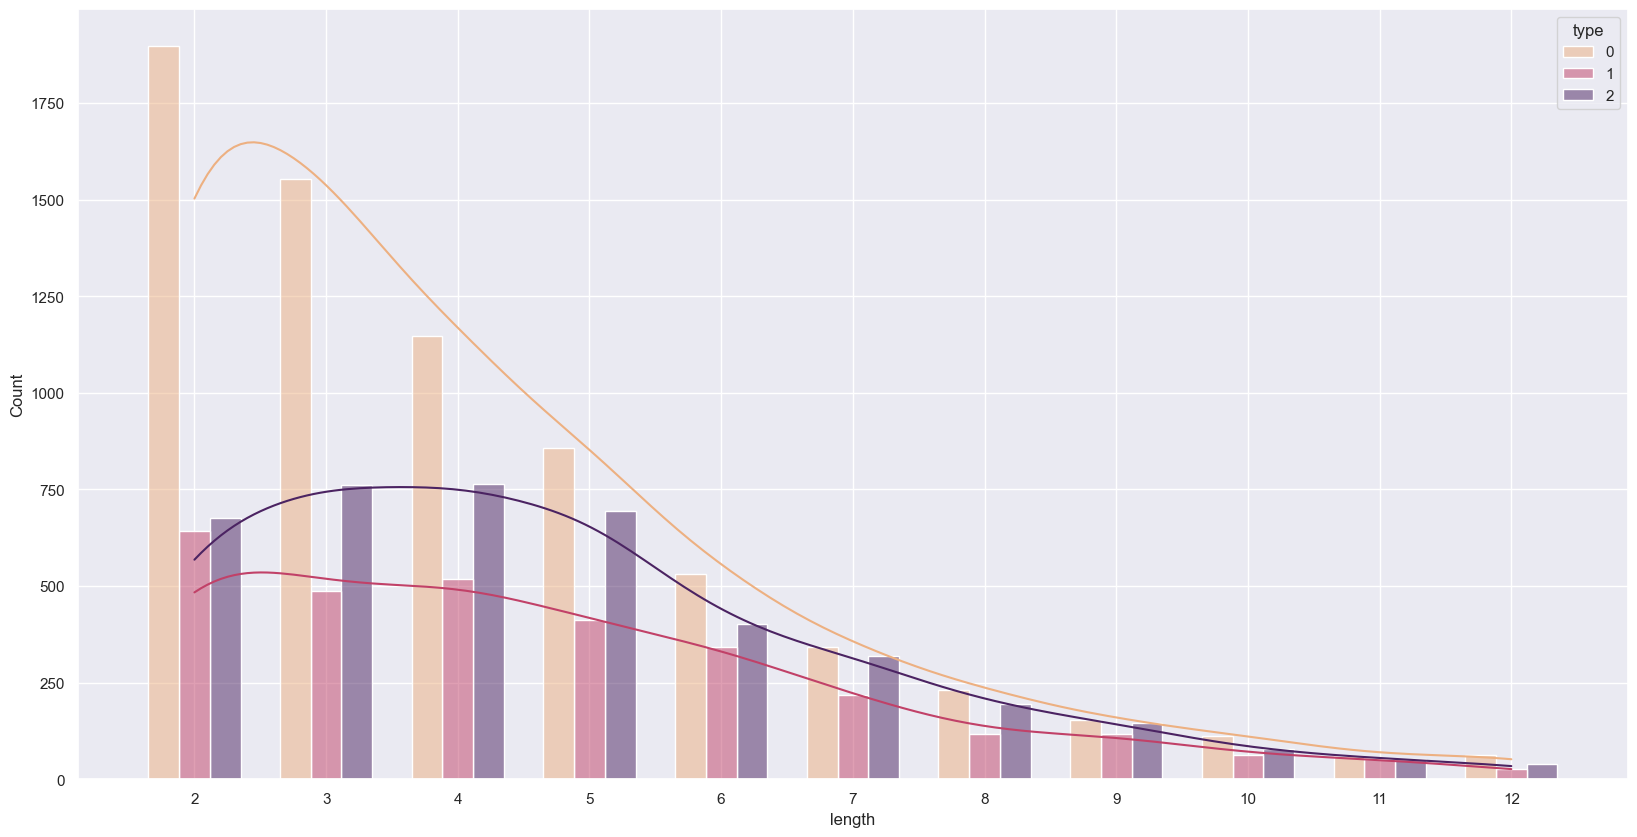

In [431]:
# plot the distribution of the type per length using hue type histplot plot and kde=true, 
sns.set_context("paper")
sns.set_style("darkgrid")
sns.set_theme(palette="flare")
fig, ax = plt.subplots( figsize=(20, 10))
# make sure that the x axis is exatly the same as the one given to the functioon

# change xticks to range(1, 22) to see the distribution of the length #
ax.set_xticks(range(1, 22))

sns.histplot(data=df_paths_multiple_u, x="length", hue="type",bins=35,stat = 'count',discrete= True, shrink=0.7,
  multiple="dodge", palette="flare", kde=True, ax=ax, kde_kws={'bw_method': 0.28})

<AxesSubplot: xlabel='score_article_similarity', ylabel='Count'>

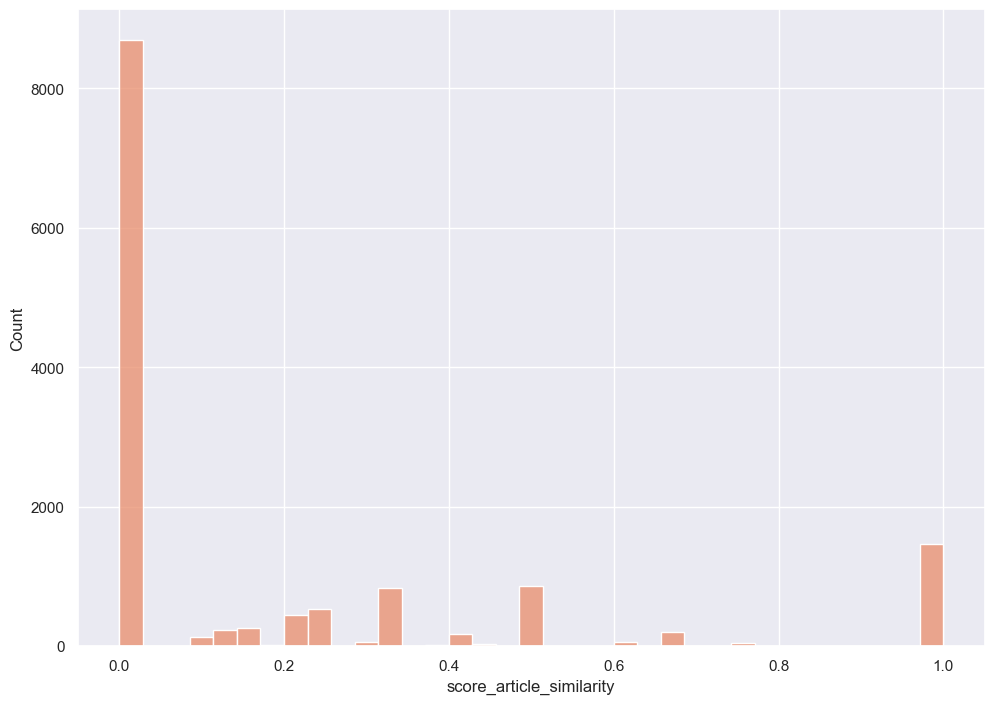

In [432]:
sns.histplot(data=df_paths_multiple_u, x="score_article_similarity",bins=35,stat = 'count')

<AxesSubplot: xlabel='score_title_similarity', ylabel='Count'>

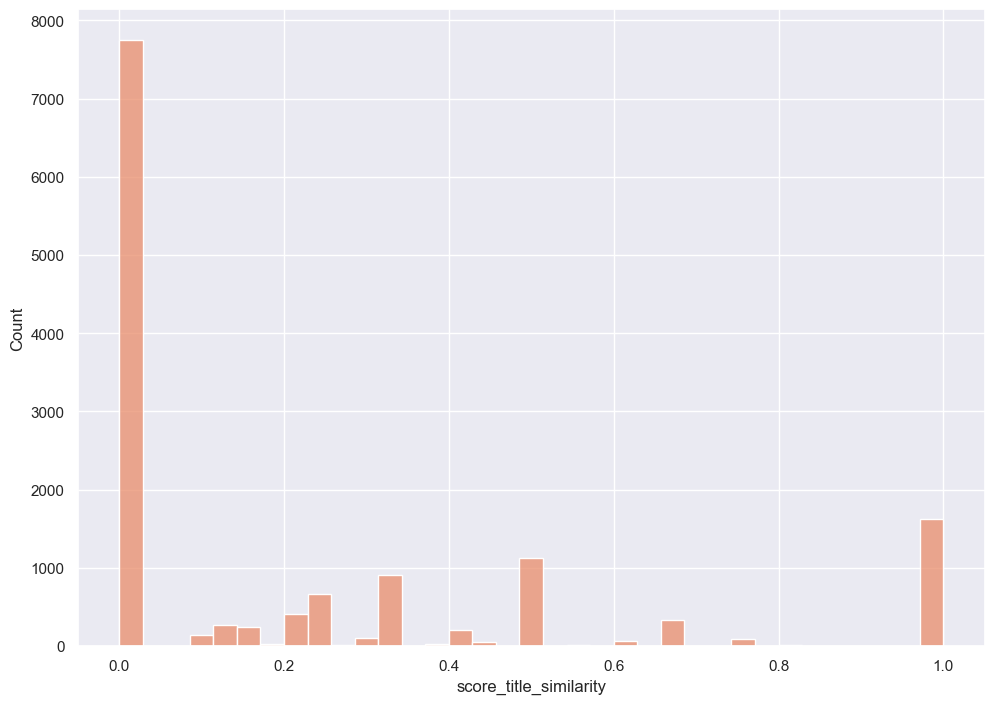

In [433]:
sns.histplot(data=df_paths_multiple_u, x="score_title_similarity",bins=35,stat = 'count')